# (Down)loading packages

In [1]:
!pip install numpy
!pip install pandas
!pip install Bio
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from Bio import SeqIO, Entrez
from Bio.Blast import NCBIWWW, NCBIXML

Entrez.email = "elian.strozyk@etu.umontpellier.fr"

# Extracting sequences

In [3]:
# All stylins identified and their NCBI ID
# 01, 02, 03, 04, 04bis, 05
NCBI_Gene_ID = ["NM_001162314.1",
                "NM_001162671.2",
                "NM_001161959.2",
                "NM_001172260.1",
                "NM_001172268.2",
                "NM_001163252.1"
               ]

NCBI_protein_ID = ["NP_001155786.1",
                   "NP_001156143.1",
                   "NP_001155431.1",
                   "NP_001165731.1",
                   "NP_001165739.1",
                   "NP_001156724.1"
                  ]

## Retrieving DNA

In [4]:
dna_search_results = Entrez.efetch("Nucleotide",
                                   id = ",".join(NCBI_Gene_ID),
                                   rettype = "fasta"
                                  )
dna_records = SeqIO.parse(dna_search_results, "fasta")
#write a fasta file with stylin's sequences
SeqIO.write(dna_records, "./stylin_dna_sequence.fasta", "fasta")

6

## Retrieving proteins

In [5]:
protein_search_results = Entrez.efetch("Protein",
                                       id = ",".join(NCBI_protein_ID),
                                       rettype = "fasta"
                                      )
protein_records = SeqIO.parse(protein_search_results, "fasta")
# write a fasta file with stylin's sequences
SeqIO.write(protein_records, "./stylin_protein_sequence.fasta", "fasta")

6

# Working with *Aphididae*
## BLAST (proteins)

Biopython's qblast() function doesn't seem to work with several sequences:
* With one sequence as input, it will return several sequences
* With several sequences as input, it will return only one sequence

As such, a way to avoid this problem is to run as many BLASTs as stylin sequences. This method is not very optimised, I might have to check other Python libraries.

BLAST's parameters were changed to be close to the online one in order to retrieve as many sequences as possible.

In [ ]:
hit_ids = [] # stores all returned protein's IDs 
for stylin in NCBI_protein_ID :
    result_handle = NCBIWWW.qblast(program = "blastp",
                                   database = "nr",
                                   sequence = stylin, # try with \n instead of comma
                                   entrez_query = "Aphididae[Organism]",
                                   expect = 0.05,
                                   gapcosts = "11 1",
                                   hitlist_size = 200
                                  )
    blast_records = NCBIXML.parse(result_handle)
    for blast_record in blast_records :
        for alignment in blast_record.alignments :
            if alignment.hit_id not in hit_ids :
                hit_ids.append(alignment.hit_id)
    with open(f"{stylin}_protein_blast.xml", "w") as fd :
        fd.write(result_handle.read()) # write a file with all BLAST results appended. Doesn't work, file's empty
    result_handle.close()
    blast_records.close()

In [6]:
print("Number of returned sequences:", len(hit_ids))

# storing all sequences as text and fasta files
with open("blast_protein_ids.txt", "w") as ft :
    ft.write("\n".join(hit_ids))

protein_search_results = Entrez.efetch("Protein",
                                       id = ",".join(hit_ids),
                                       rettype = "fasta"
                                      )
protein_records = SeqIO.parse(protein_search_results, "fasta")
SeqIO.write(protein_records, "./blast_protein_sequences.fasta", "fasta")

NameError: name 'hit_ids' is not defined

In [ ]:
# Creation of a dictionary to stock all species and their sequence count
import re

dictionary = {}
with open("blast_protein_sequences.fasta", "r") as file :
    for line in file :
        for key in re.findall("\[(.*)\]", line) :
            if key not in dictionary :
                dictionary[key] = 1
            else :
                dictionary[key] += 1

Text(0, 0.5, 'Count')

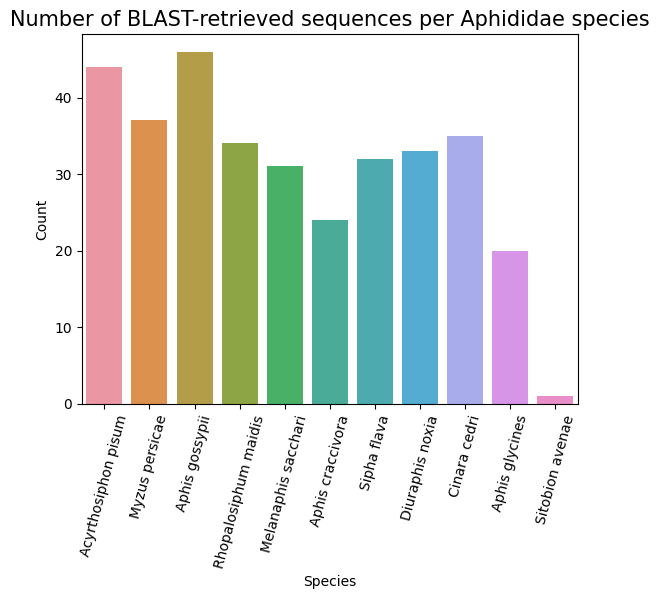

In [49]:
# plotting the resulting dictionary
import seaborn as sns

plot = sns.barplot(x = list(dictionary.keys()),
                   y = list(dictionary.values())
                  )
plot.set_xticklabels(plot.get_xticklabels(), rotation = 75)
plot.set_title("Number of BLAST-retrieved sequences per Aphididae species", size = 15)
plot.set_xlabel("Species")
plot.set_ylabel("Count")

## MetaPhOrs (proteins) parsing

In [62]:
unique_seq = []
with open("../metaphors/stylin_orthologs_aphididae.metaphors.fasta") as fd :
    for record in SeqIO.parse(fd, "fasta") :
        if record.description not in unique_seq :
            unique_seq.append(record.description)
    print(len(unique_seq))

111


## Alignment

# Summary

* Extraction of stylin's DNA and protein sequences
* BLAST with protein sequences for *Aphididae*, returns 337 sequences

# Improvements

* Run a single BLAST with all sequences instead of 6 BLASTs with one sequence